In [1]:
import os
import platform
import sys

def get_project_root() -> str:
    system = platform.system()
    return r"D:\Users\tcshore\Documents\Projects\Tangrams\Data" if system == "Windows" else "/home/tshore/Projects/tangrams-restricted/Data"

infile_path = os.path.join(get_project_root(), "wordscores-inflected-small.tsv")
print("Will read file \"{}\".".format(infile_path), file=sys.stderr)

Will read file "D:\Users\tcshore\Documents\Projects\Tangrams\Data\wordscores-inflected-small.tsv".


In [2]:
import csv
import pandas as pd

RESULTS_FILE_CSV_DIALECT = csv.excel_tab
# NOTE: "category" dtype doesn't work with pandas-0.21.0 but does with pandas-0.21.1
__RESULTS_FILE_DTYPES = {"DYAD": "category", "ENTITY" : "category", "IS_TARGET": bool, "IS_OOV": bool,
				 "IS_INSTRUCTOR": bool, "SHAPE": "category", "ONLY_INSTRUCTOR": bool, "WEIGHT_BY_FREQ": bool}

def read_results_file(inpath: str, encoding: str) -> pd.DataFrame:
	print("Reading \"{}\" using encoding \"{}\".".format(inpath, encoding), file=sys.stderr)
	result = pd.read_csv(inpath, dialect=RESULTS_FILE_CSV_DIALECT, sep=RESULTS_FILE_CSV_DIALECT.delimiter,
						 float_precision="round_trip",
						 encoding=encoding, memory_map=True, dtype=__RESULTS_FILE_DTYPES)
	return result

cv_results = read_results_file(infile_path, "windows-1252")
print("Read {} cross-validation results for {} dyad(s).".format(cv_results.shape[0], cv_results["DYAD"].nunique()),
      file=sys.stderr)

Reading "D:\Users\tcshore\Documents\Projects\Tangrams\Data\wordscores-inflected-small.tsv" using encoding "windows-1252".
Read 67060 cross-validation results for 3 dyad(s).


In [3]:
OOV_LABEL = "__OOV__"
    
print("Replacing OOV words with label \"{}\".".format(OOV_LABEL), file=sys.stderr)
cv_results.loc[cv_results["IS_OOV"] == True, "WORD"] = OOV_LABEL

Replacing OOV words with label "__OOV__".


In [4]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

# Create vocab before splitting training and testing DFs so that the word feature set is stable
print("Fitting one-hot encoder for vocabulary of size {}.".format(cv_results["WORD"].nunique()), file=sys.stderr)
# https://machinelearningmastery.com/how-to-one-hot-encode-sequence-data-in-python/
# integer encode
label_encoder = LabelEncoder()
vocab_labels = label_encoder.fit_transform(cv_results["WORD"])
cv_results["WORD_LABEL"] = vocab_labels
#print(vocab_labels)
# binary encode
onehot_encoder = OneHotEncoder(sparse=False)
vocab_labels = vocab_labels.reshape(len(vocab_labels), 1)
onehot_encoder.fit(vocab_labels)
#assert onehot_encoder.n_values_ == len(vocab_words)
#vocab_onehot_encoded = onehot_encoder.fit_transform(vocab_labels)
#print(vocab_onehot_encoded)
# invert first example
#inverted = label_encoder.inverse_transform([np.argmax(vocab_onehot_encoded[0, :])])
#print(inverted)

Fitting one-hot encoder for vocabulary of size 249.


OneHotEncoder(categorical_features='all', dtype=<class 'numpy.float64'>,
       handle_unknown='error', n_values='auto', sparse=False)

In [5]:
from typing import Tuple

import numpy as np

def find_target_ref_rows(df: pd.DataFrame) -> pd.DataFrame:
	result = df.loc[df["IS_TARGET"] == True]
	result_row_count = result.shape[0]
	complement_row_count = df.loc[~df.index.isin(result.index)].shape[0]
	assert result_row_count + complement_row_count == df.shape[0]
	print("Found {} non-target rows and {} target rows. Ratio: {}".format(complement_row_count, result_row_count,
																		 complement_row_count / float(
																			 result_row_count)), file=sys.stderr)
	return result

def split_training_testing(df: pd.DataFrame, test_set_size: int) -> Tuple[pd.DataFrame, pd.DataFrame]:
	dyad_ids = df["DYAD"].unique()
	training_set_size = len(dyad_ids) - test_set_size
	if training_set_size < 1:
		raise ValueError("Desired test set size is {} but only {} dyads found.".format(test_set_size, len(dyad_ids)))
	else:
		training_set_dyads = frozenset(np.random.choice(dyad_ids, training_set_size, replace=False))
		assert len(training_set_dyads) == training_set_size
		print("Training set dyads: {}".format(sorted(training_set_dyads)), file=sys.stderr)
		training_set_idxs = df["DYAD"].isin(training_set_dyads)
		training_set = df.loc[training_set_idxs]
		test_set = df.loc[~training_set_idxs]
		test_set_dyads = frozenset(test_set["DYAD"].unique())
		print("Test set dyads: {}".format(sorted(test_set_dyads)), file=sys.stderr)
		assert not frozenset(training_set["DYAD"].unique()).intersection(frozenset(test_set_dyads))
		return training_set, test_set
    
# https://stackoverflow.com/a/47815400/1391325
cv_results.sort_values("TOKEN_SEQ_ORDINALITY", inplace=True)
training_df, test_df = split_training_testing(cv_results, 1)
# Only train on "true" referents
training_df = find_target_ref_rows(training_df)

Training set dyads: ['20', '21']
Test set dyads: ['22']
Found 42978 non-target rows and 2262 target rows. Ratio: 19.0


In [6]:
from collections import defaultdict
from typing import DefaultDict, Iterator, List, Sequence

import keras.utils

class DataGeneratorFactory(object):

	@staticmethod
	def __group_by_seq_len(seq_xy: pd.Series) -> DefaultDict[int, List[Tuple[np.matrix, np.ndarray]]]:
		result = defaultdict(list)
		for xy in seq_xy:
			seq_len = xy[0].shape[0]
			result[seq_len].append(xy)
		return result

	def __init__(self, onehot_encoder: OneHotEncoder):
		self.onehot_encoder = onehot_encoder

	@property
	def input_feature_count(self) -> int:
		word_features = self.onehot_encoder.n_values_[0]
		return word_features + 1

	@property
	def output_feature_count(self) -> int:
		return 1

	def __call__(self, df: pd.DataFrame) -> "TokenSequenceSequence":
		sequence_groups = df.groupby(
			("CROSS_VALIDATION_ITER", "DYAD", "ROUND", "UTT_START_TIME", "UTT_END_TIME", "ENTITY"), sort=False)
		print("Generating data for {} entity token sequence(s).".format(len(sequence_groups)), file=sys.stderr)
		seq_xy = sequence_groups.apply(self.__create_seq_xy)
		len_dict = self.__group_by_seq_len(seq_xy)
		print("Created {} batches, one for each unique sequence length.".format(len(len_dict)), file=sys.stderr)
		seq_batches_by_len = tuple(len_dict.values())
		return TokenSequenceSequence(seq_batches_by_len)

	def __create_datapoint_x(self, row: pd.Series) -> Tuple[np.ndarray,]:
		# word_features = [0.0] * len(self.__vocab_idxs)
		# The features representing each individual vocabulary word are at the beginning of the feature vector
		# word_features[self.__vocab_idxs[row["WORD"]]] = 1.0
		# word_label = self.label_encoder.transform(row["WORD"])
		word_label = row["WORD_LABEL"]
		# print("Word label: {}".format(word_label), file=sys.stderr)
		# "OneHotEncoder.transform(..)" returns a matrix even if only a single value is passed to it, so get just the first (and only) row
		word_features = self.onehot_encoder.transform(word_label)[0]
		# print("Word features: {}".format(word_features), file=sys.stderr)
		# The word label for the one-hot encoding is that with the same index as the column that has a "1" value, i.e. the highest value in the vector of one-hot encoding values
		# inverse_label = np.argmax(word_features)
		# assert inverse_label == word_label
		# inverse_word = self.label_encoder.inverse_transform([inverse_label])
		# print("Inverse word label: {}".format(inverse_label), file=sys.stderr)
		is_instructor = 1.0 if row["IS_INSTRUCTOR"] else 0.0
		# is_target = 1.0 if row["IS_TARGET"] else 0.0
		other_features = np.array((is_instructor,))
		# result = word_features + other_features
		result = np.concatenate((word_features, other_features))
		# print("Created a vector of {} features.".format(len(result)), file=sys.stderr)
		# NOTE: Returning a tuple is a hack in order to return an instance of "np.ndarray" from "DataFrame.apply()"
		return result,

	def __create_seq_x_matrix(self, seq_df: pd.DataFrame) -> np.matrix:
		# NOTE: The returned tuples have to be unpacked outside of the "apply(..)" function
		vectors = seq_df.apply(self.__create_datapoint_x, axis=1)
		return np.matrix(tuple(vector[0] for vector in vectors))

	def __create_seq_xy(self, seq_df: pd.DataFrame) -> Tuple[np.matrix, np.ndarray]:
		x = self.__create_seq_x_matrix(seq_df)
		y = seq_df["PROBABILITY"].values
		return x, y


class TokenSequenceSequence(keras.utils.Sequence):
	"""
	A sequence (i.e. less confusingly a dataset) of token sequences, each of which is for a given distinct entity, i.e. possible referent.
	"""

	def __init__(self, seq_batches_by_len: Sequence[Sequence[Tuple[np.matrix, np.ndarray]]]):
		self.seq_batches_by_len = seq_batches_by_len

	def __len__(self) -> int:
		return len(self.seq_batches_by_len)

	def __getitem__(self, idx: int) -> Tuple[np.ndarray, np.ndarray]:
		# print("Getting batch idx {}.".format(idx), file=sys.stderr)
		batch = self.seq_batches_by_len[idx]
		seq_x = tuple(x for x, y in batch)
		x = np.asarray(seq_x)
		# print("X shape: {}".format(x.shape), file=sys.stderr)
		seq_y = tuple(y for x, y in batch)
		if any(len(y.shape) > 1 for y in seq_y):
			raise ValueError("Output feature vectors with a dimensionality greater than 1 are not supported.")
		y = np.asarray(tuple(y[0] for y in seq_y))
		# y = np.asarray(seq_y)
		# print("Y shape: {}".format(y.shape), file=sys.stderr)
		return x, y
    

data_generator_factory = DataGeneratorFactory(onehot_encoder)

Using TensorFlow backend.


In [7]:
from keras.layers import Dense
from keras.layers import LSTM
from keras.models import Sequential

def create_model(input_feature_count: int, output_feature_count: int) -> Sequential:
	result = Sequential()
	# word_embeddings = Embedding(len(vocab), embedding_vector_length, input_length=max_review_length)
	# model.add(word_embeddings)
	# model.add(Embedding(top_words, embedding_vector_length, input_length=max_review_length))
	# input shape is a pair of (timesteps, features) <https://stackoverflow.com/a/44583784/1391325>
	input_shape = (None, input_feature_count)
	print("Input shape: {}".format(input_shape), file=sys.stderr)
	units = output_feature_count
	print("Units: {}".format(units), file=sys.stderr)
	lstm = LSTM(input_shape=input_shape, units=units, dropout=0.1, recurrent_dropout=0.1)
	# lstm = LSTM(batch_input_shape = training_x.shape, stateful = True, units=len(training_y.shape))
	result.add(lstm)
	result.add(Dense(units, activation='softmax'))
	result.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
	result.summary(print_fn=lambda line : print(line, file=sys.stderr))
	return result

model = create_model(data_generator_factory.input_feature_count, data_generator_factory.output_feature_count)

Input shape: (None, 250)
Units: 1


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 1)                 1008      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 2         
Total params: 1,010
Trainable params: 1,010
Non-trainable params: 0
_________________________________________________________________
None


In [8]:
import multiprocessing

print("Generating training data token sequences.", file=sys.stderr)
training_data_generator = data_generator_factory(training_df)
print("Generating validation data token sequences.", file=sys.stderr)
validation_data_generator = data_generator_factory(find_target_ref_rows(test_df))

# train LSTM
model = create_model(data_generator_factory.input_feature_count, data_generator_factory.output_feature_count)
# train LSTM
epochs = 250
print("Training model using {} epoch(s).".format(epochs), file=sys.stderr)
workers = max(multiprocessing.cpu_count() // 2, 1)
print("Using {} worker thread(s).".format(workers), file=sys.stderr)
training_history = model.fit_generator(training_data_generator, epochs=epochs, verbose=0,
                                       validation_data=validation_data_generator, use_multiprocessing=False,
                                       workers=workers)
    
    

Generating training data token sequences.
Generating data for 273 entity token sequence(s).
Created 28 batches, one for each unique sequence length.
Generating validation data token sequences.
Found 20729 non-target rows and 1091 target rows. Ratio: 19.0
Generating data for 143 entity token sequence(s).
Created 28 batches, one for each unique sequence length.
Input shape: (None, 250)
Units: 1


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 1)                 1008      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 2         
Total params: 1,010
Trainable params: 1,010
Non-trainable params: 0
_________________________________________________________________
None


Training model using 250 epoch(s).
Using 4 worker thread(s).


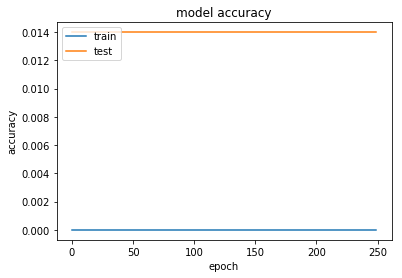

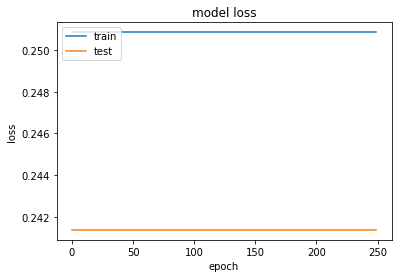

In [11]:
import matplotlib.pyplot as plt

# https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/

# list all data in history
#print(training_history.history.keys())
# summarize history for accuracy
plt.plot(training_history.history['acc'])
plt.plot(training_history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(training_history.history['loss'])
plt.plot(training_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [10]:
# test LSTM

import logging

def onehot_encodings(features : np.ndarray, onehot_encoder) -> np.ndarray:
    """
    :param features: A 2D array of feature vectors, each of which starts with one-hot encoding features. Any other features follow those.
    :param onehot_encoder: The instance used to encode the original values.
    :return: A 2D numpy array consisting only of one-hot encoding features.
    """
    feature_count = onehot_encoder.n_values_[0]
    return features[:,:feature_count + 1]

def onehot_encoded_word(onehot_encodings : np.ndarray, label_encoder) -> str:
    # Check if there are any non-zero values
    if onehot_encodings.any():
        word_label = onehot_encodings.argmax()
        result = label_encoder.inverse_transform([word_label])[0]
    else:
        result = "(padding)"
    return result

def word(features : np.ndarray, label_encoder, onehot_encoder) -> str:
    feature_count = onehot_encoder.n_values_[0]
    onehot = features[:feature_count + 1]
    return onehot_encoded_word(onehot, label_encoder)

def word_seq(x : np.ndarray, label_encoder, onehot_encoder) -> np.ndarray:
    word_features = onehot_encodings(x, onehot_encoder)
    return np.apply_along_axis(lambda arr : onehot_encoded_word(arr, label_encoder), 1, word_features)

def create_padded_seq_matrix(group: pd.DataFrame, seq_matrix_factory):
    seq_matrices = tuple(seq_matrix_factory(group))
    print("Created a dataset composed of {} sequence(s), with a max sequence length of {}.".format(len(seq_matrices), max(m.shape[0] for m in seq_matrices)), file=sys.stderr)
    print("Padding data sequences.", file=sys.stderr)
    return keras.preprocessing.sequence.pad_sequences(seq_matrices, maxlen=None, padding='pre', truncating='pre', value=0.0)
    

def test_token_seq(token_seq_group : pd.DataFrame, seq_matrix_factory, model: Sequential, label_encoder, onehot_encoder): 
    entity_groups = token_seq_group.groupby("ENTITY", as_index=False, sort=False)
    entity_matrices = tuple(entity_groups.apply(lambda group : (group.name, seq_matrix_factory(group))))
    #for _, m in entity_matrices:
    #    y = m[:, -1]
    #    print(y) 
    
    logging.debug("Created matrices for %d entities, with a max sequence length of %d.", len(entity_matrices), max(m.shape[0] for _, m in entity_matrices))
    logging.debug("Padding entity test data sequences.")
    test_batch = keras.preprocessing.sequence.pad_sequences(tuple(m for _, m in entity_matrices), maxlen=None, padding='pre', value=0.0, dtype='int32')
    print(test_batch[:, :, :-1])
    logging.debug("Test batch shape: %s", test_batch.shape)
    test_x, test_y = split_xy(test_batch)
    
    
    for group_name, m in entity_matrices:
        m = np.expand_dims(m, axis=0)
        print(m.shape)
        x = m[:, :, :-1]
        print(x.shape)
        y = m[:, :, -1]
        print(y.shape)
        model.predict(x, verbose=0, batch_size=1)
    
    #logging.debug("Test X shape: %s", test_x.shape)
    #logging.debug("Test Y shape: %s", test_y.shape)
    # Classify all sets of datapoints for each entity as a single batch
    #entity_predicted_scores = model.predict(test_x, verbose=0)
    
    max_score = 0
    for idx in range(0, test_x.shape[0]):
        entity_id = entity_matrices[idx][0]
        # Get the scores for each entity
        entity_x = test_x[idx]
        logging.debug("Re-scoring token sequence for entity %s: %s", entity_id, word_seq(entity_x, label_encoder, onehot_encoder))
        entity_orig_scores = test_y[idx]
        for tok_idx, features in enumerate(entity_x):
            w = word(features, label_encoder, onehot_encoder)
            s = entity_orig_scores[tok_idx]
            print("{}; Orig score: {}".format(w, s))
        
        max_score = max(max_score, entity_orig_scores.argmax())
        #print(entity_orig_scores)
        orig_score = entity_orig_scores.sum()
        #predicted_scores = entity_predicted_scores[idx]
        #print(predicted_scores)
        #rescored = np.dot(entity_orig_scores, predicted_scores)
        #logging.warning("Original score: %f; New score: %f", orig_score, rescored)
                        
    print("Max score: {}".format(max_score))
            
token_seq_groups = test_df.groupby(
                ("CROSS_VALIDATION_ITER", "DYAD", "ROUND", "UTT_START_TIME", "UTT_END_TIME"),
                as_index=False, sort=False)
print("Will test {} token sequences.".format(len(token_seq_groups)), file=sys.stderr)
test_results = token_seq_groups.apply(lambda group: test_token_seq(group, seq_matrix_factory, model, label_encoder, onehot_encoder))

                        
#test_x, test_y = split_xy(test_matrix)
#print("Training X shape: {}".format(test_x.shape), file=sys.stderr)
#print("Training Y shape: {}".format(test_y.shape), file=sys.stderr)

#seq_predicted_values = model.predict(test_x, verbose=0)
#model.reset_states()
#print("result.shape = {}".format(seq_predicted_values.shape), file=sys.stderr)
#for i, tested_seq in enumerate(test_x):
#    word_features = onehot_encodings(tested_seq, onehot_encoder)
    #print("word features: {}".format(word_features))
    #print("Tested sequence: {}".format(tested_seq))
    #print("Tested sequence shape: {}".format(tested_seq.shape))
    #seq_labels = word_features.argmax(axis=1)
    #print("Inverse labels: {}".format(inverse_labels))
    #seq_words = label_encoder.inverse_transform(seq_labels)
#    seq_words = np.apply_along_axis(lambda arr : onehot_encoded_word(arr, label_encoder), 1, word_features)
    #print("Inverse word labels: {}".format(seq_words))
#    predicted_values = seq_predicted_values[i]
#    assert tested_seq.shape[:-1] == predicted_values.shape
    #assert tested_seq.shape[:-1] == actual_values.shape
    #rint("Predicted values: {}".format(predicted_values))
#    actual_values = test_y[i]
#    assert predicted_values.shape == actual_values.shape
    
#    differences = predicted_values - actual_values
#    print("[Predicted_val - Actual_val]: {}".format(differences))
    #print("Actual values: {}".format(actual_values))
	#print('X=%.1f y=%.1f, yhat=%.1f' % (seq1[i], seq1[i+1], result[i]))

Will test 143 token sequences.


NameError: name 'seq_matrix_factory' is not defined